# ATLAS OpenData Machine Learning Tutorial

This tutorial takes you through how to download ATLAS OpenData, convert the data into a format suitable for building machine learning models, and then build such a model: a "simple" deep neural network for classifying two processes as signal and background.

The signal process we consider is the production of a Higgs boson through gluon-gluon fusion, where the Higgs then decays to two W bosons which both decay leptonically. 
The background process is top-antitop quark pair production, with both tops decaying through two intermediate W bosons which also decay leptonically.
Thus the final state consists of two charged leptons, some missing transverse energy, and some jets.

### Aims of this tutorial
* Pipeline for turning ATLAS OpenData for Education ROOT files into a format for machine learning
* Building and training a simple DNN model

### Downloading data

In [6]:
!curl -o signal_nov18.root https://opendata.cern/record/15003/files/mc_345324.ggH125_WW2lep.2lep.root


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  139M  100  139M    0     0  1741k      0  0:01:22  0:01:22 --:--:-- 2065k3058k  0:00:35  0:00:31 1638k550k


In [4]:
!curl -O https://opendata.cern/record/15003/files/mc_410000.ttbar_lep.2lep.root


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 18  832M   18  154M    0     0  1942k      0  0:07:18  0:01:21  0:05:57 1957k      0      0 --:--:-- --:--:-- --:--:--     0  0:06:31 2126k0:07:11  0:00:27  0:06:44 2015k  0:07:01  0:00:52  0:06:09 1410k^C


### Preparing data for machine learning

We will use the scikit-HEP software stack to:
* Load ROOT files
* Perform some basic selections
* Convert directly to PyTorch tensors

If you are not interested in this part, you can skip

In [8]:
import uproot

In [12]:
file_signal = uproot.open("signal_nov18.root")
tree_signal = file_signal["mini"]

We will extract only jet and lepton kinematics with some basic cuts

In [128]:
signal_array = tree_signal.arrays(["lep_pt", "lep_eta", "lep_phi", "lep_E", 
                                  "jet_pt", "jet_eta", "jet_phi", "jet_E",
                                  "met_et", "met_phi"])

This array contains only lepton, jet and MET information.

In [21]:
import awkward as ak

In [131]:
# Creates a mask which is True for events with at least 2 jets
Number_jets_mask = ak.num(signal_array["jet_pt"]) == 2

# Apply the mask to select only those events
signal_filtered_array = signal_array[Number_jets_mask]

A more complex selection could apply a filter on lepton pT and then require that two leptons remain after this

In [132]:
# Construct mask 
lep_geq_10GEV_mask = signal_filtered_array["lep_pt"] >= 10e3

# Apply the mask to select only leptons with pt >= 10 GeV
signal_filtered_array["lep_pt"] = signal_filtered_array["lep_pt"][lep_geq_10GEV_mask]
signal_filtered_array["lep_eta"] = signal_filtered_array["lep_eta"][lep_geq_10GEV_mask]
signal_filtered_array["lep_phi"] = signal_filtered_array["lep_phi"][lep_geq_10GEV_mask]
signal_filtered_array["lep_E"] = signal_filtered_array["lep_E"][lep_geq_10GEV_mask]

In [135]:
# Now require that we have at least two leptons 
lep_geq_2_mask = ak.num(signal_filtered_array["lep_pt"]) >= 2
final_signal_array = signal_filtered_array[lep_geq_2_mask]

In [136]:
print("Number of events in the original signal dataset:", len(signal_array))
print("Number of events with at least 2 jets:", len(signal_filtered_array))
print("Number of events with at least 2 jets and 2 leptons with pt >= 10 GeV:", len(final_signal_array))

Number of events in the original signal dataset: 628685
Number of events with at least 2 jets: 110704
Number of events with at least 2 jets and 2 leptons with pt >= 10 GeV: 99070


## Converting to PyTorch

In [62]:
import torch

For this exercise, we will turn everything into a torch tensor. 
The tensor will be two-dimensional and have the shape `number_of_events X number_of_branches`. 
This is because we are going to train a deep neural network, which will require each data instance (each event) to be a 1D vector of values.

 Let's practice just by taking the kinematics of the zeroth lepton in each event, converting these into individual tensors and then stacking them together.

In [137]:
# Convert the lepton kinematic variables of the zeroth lepton in each event to PyTorch tensors. The [:,0] indexing selects the zeroth lepton from each event.
lepton0_pt_tensor  = torch.tensor(final_signal_array["lep_pt"][:,0])
lepton0_eta_tensor = torch.tensor(final_signal_array["lep_eta"][:,0])
lepton0_phi_tensor = torch.tensor(final_signal_array["lep_phi"][:,0])
lepton0_e_tensor   = torch.tensor(final_signal_array["lep_E"][:,0])

In [138]:
# Stack the tensors into a single tensor
signal_tensor = torch.stack([lepton0_pt_tensor, 
             lepton0_eta_tensor, 
             lepton0_phi_tensor, 
             lepton0_e_tensor], dim=1)

We now have an object that we can use to train machine learning tools!

I have written this in a verbose way to hopefully make it clear what is happening. 
There are many equivalent ways to format our input data in the torch tensor format we desire.


In [139]:
data_tensor = torch.zeros(len(final_signal_array), 18)  

for i,branch in enumerate(["lep_pt","lep_eta","lep_phi","lep_E"]):
    data_tensor[:,i] = torch.tensor(final_signal_array[branch][:,0])
    data_tensor[:,i+4] = torch.tensor(final_signal_array[branch][:,1])
    
for i,branch in enumerate(["jet_pt","jet_eta","jet_phi","jet_E"]):
    data_tensor[:,i+8] = torch.tensor(final_signal_array[branch][:,0])
    data_tensor[:,i+12] = torch.tensor(final_signal_array[branch][:,1])
       
data_tensor[:,16] = torch.tensor(final_signal_array["met_et"])
data_tensor[:,17] = torch.tensor(final_signal_array["met_phi"])

Now we'd need to do the same thing for the background dataset. See function that wraps all of this

In [199]:
from data_prep import prepare_data

In [ ]:
signal_tensor = prepare_data("signal_nov18.root")
background_tensor = prepare_data("~/Downloads/mc_410000.ttbar_lep.2lep.root")

## Preparing the data for machine learning models

We have our data in the correct format, but robust machine learning requires some additional formatting. 
First we want to split the data into training, testing and validation samples. I like to use the scikit-learn functionality for this

In [153]:
# First combine the signal and background tensors 
input_tensor = torch.cat([signal_tensor,background_tensor[:120000]], dim=0)
target_tensor = torch.cat([torch.ones(len(signal_tensor)), torch.zeros(120000)], dim=0)

In [152]:
input_tensor.shape

torch.Size([219070, 18])

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(input_tensor, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

Y_train, Y_temp = train_test_split(target_tensor, test_size=0.2, random_state=42)
Y_val, Y_test = train_test_split(Y_temp, test_size=0.5, random_state=42)

Now we want to scale the data. One can use `sklearn.preprocessing.standard_scaler` for this, but I have explicitly written the Z-transformation in torch so you can see what's happening

In [156]:
mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True)

# Transform step: Apply the standardization formula
X_train_scaled = (X_train - mean) / std
X_val_scaled = (X_val - mean) / std
X_test_scaled = (X_test - mean) / std

Now we have everything we need to train our model!

## Building our DNN

In [163]:
Nfeatures = X_train.shape[1]

In [201]:
# Just write this as nn.Sequential
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(Nfeatures, 32),
    nn.Sigmoid(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)

In [202]:
# Define the loss function and optimizer
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.Rprop(model.parameters(), lr=0.05)

In [203]:
train_losses = []
val_losses   = []

N_epochs = 50

for epoch in range(N_epochs):

    model.train()
    # tell the optimizer to begin an optimization step
    optimizer.zero_grad()

    # forward pass
    # use the model as a prediction function: features → prediction
    predictions = model(X_train_scaled)

    # compute the loss (χ²) between these predictions and the intended targets
    loss = criterion(predictions.squeeze(), Y_train)

    # tell the loss function and optimizer to end an optimization step
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{N_epochs}], Loss: {loss.item():.4f}')

    # add in the validation loss part
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_predictions = model(X_val_scaled)
        val_loss = criterion(val_predictions, Y_val.reshape(-1,1))
        val_losses.append(val_loss)


Epoch [1/50], Loss: 0.6924
Epoch [2/50], Loss: 0.7164
Epoch [3/50], Loss: 0.6799
Epoch [4/50], Loss: 0.6190
Epoch [5/50], Loss: 0.6022
Epoch [6/50], Loss: 0.5839
Epoch [7/50], Loss: 0.5740
Epoch [8/50], Loss: 0.5622
Epoch [9/50], Loss: 0.5499
Epoch [10/50], Loss: 0.5414
Epoch [11/50], Loss: 0.5329
Epoch [12/50], Loss: 0.5272
Epoch [13/50], Loss: 0.5240
Epoch [14/50], Loss: 0.5216
Epoch [15/50], Loss: 0.5193
Epoch [16/50], Loss: 0.5180
Epoch [17/50], Loss: 0.5159
Epoch [18/50], Loss: 0.5140
Epoch [19/50], Loss: 0.5119
Epoch [20/50], Loss: 0.5094
Epoch [21/50], Loss: 0.5066
Epoch [22/50], Loss: 0.5032
Epoch [23/50], Loss: 0.4992
Epoch [24/50], Loss: 0.4949
Epoch [25/50], Loss: 0.4900
Epoch [26/50], Loss: 0.4850
Epoch [27/50], Loss: 0.4803
Epoch [28/50], Loss: 0.4767
Epoch [29/50], Loss: 0.4722
Epoch [30/50], Loss: 0.4676
Epoch [31/50], Loss: 0.4628
Epoch [32/50], Loss: 0.4577
Epoch [33/50], Loss: 0.4525
Epoch [34/50], Loss: 0.4470
Epoch [35/50], Loss: 0.4418
Epoch [36/50], Loss: 0.4361
E

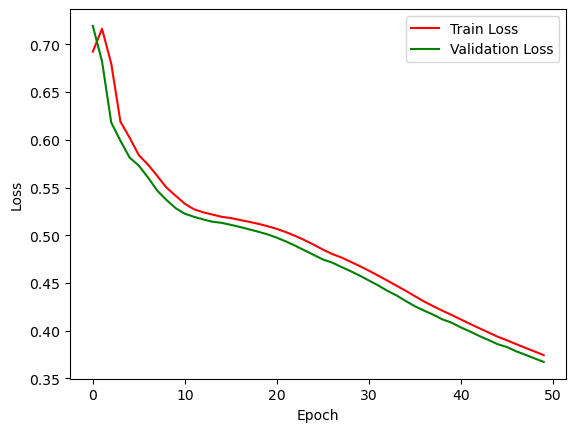

In [204]:
# Plot loss function for training and validation sets
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss', color='red')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])

## Evaluating our model

Our DNN is now trained, which means that the internal parameters (weights and biases) are hopefully set to "optimal" values (where optimality is achieved by gradient descent in the loss space).

In [214]:
# Model evaluation is simple: call the model
# We detach the array 
y_pred = model(X_test_scaled).detach()

The tensor `y_pred` gives a continuous score, not a binary decision. For a well trained binary classifier, these scores should show good separation, which can be seen through a simple plot

Text(0, 0.5, 'Events')

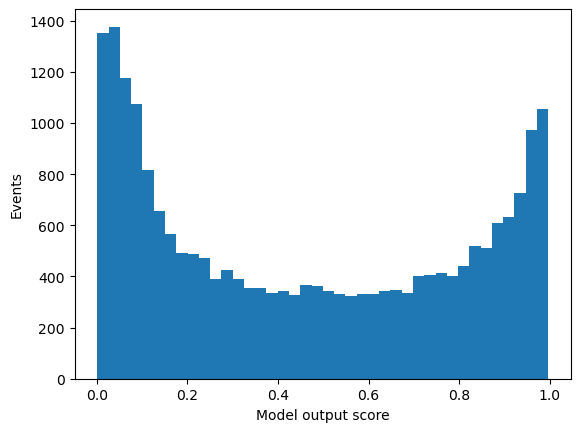

In [221]:
# Plot the scores 
plt.hist(y_pred,bins=40)
plt.xlabel('Model output score')
plt.ylabel('Events')

There are two pronounced peaks at 0 and 1 indicating that the DNN can separate the data into two classes very well. 

Let's now evaluate whether the model is predicting the classes correctly. This is an arbitrary choice on our part: we must define some threshold value for the model output, above which we consider events to be classed as signal, and below which as background. Based on the above plot, the standard value of 0.5 is appropriate

In [225]:
threshold = 0.5
y_pred_labels = (y_pred >= threshold).float()

Scikit-learn is useful for providing metrics for evaluating model performance

In [228]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_test, y_pred_labels)
print(accuracy)

0.8369927420459214


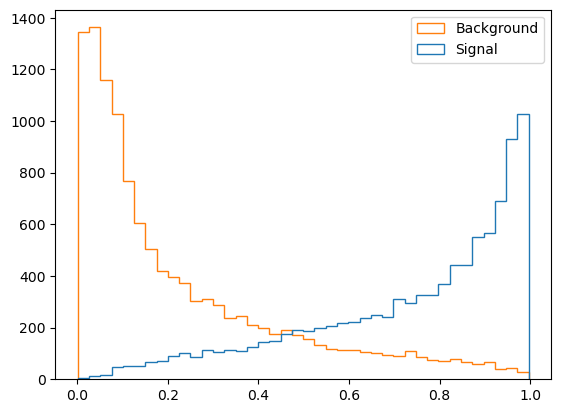

In [240]:
# Plotting the model outputs for signal and background separately
signal_scores = y_pred[Y_test == 1].flatten()
background_scores = y_pred[Y_test == 0].flatten()
plt.hist([signal_scores,background_scores], bins=40, histtype='step', label=['Signal','Background'])
plt.legend()

Text(0, 0.5, 'True Positive Rate')

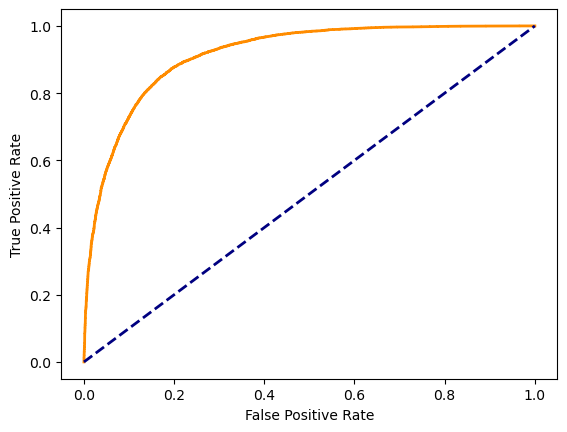

In [243]:
# ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

#  Splitting the process up 

We have looked at all stages of the ML pipeline in one notebook. It is good practice to split our ML pipeline up into separate Python scripts: one to prepare the data, one to load it into the PyTorch model and train, one to evaluate, and one to study the results. Part of this is then saving our processed data in a format which is suitable for then reading in to PyTorch i.e saving the data to HDF5 format (industry standard) after applying the selections, and then loading these HDF5 files into torch tensors...

We will convert the `signal_array` to a structured numpy array and then use the `h5py` module to save this. Let's look at the single lepton example

In [264]:
import numpy as np

# First we create a unstructured numpy array from the awkward array, by converting each branch to a numpy array and stacking them column-wise

unstructured_numpy_array = np.column_stack([
    final_signal_array['lep_pt'][:,0].to_numpy(),
    final_signal_array['lep_eta'][:,0].to_numpy(),
    final_signal_array['lep_phi'][:,0].to_numpy(),
    final_signal_array['lep_E'][:,0].to_numpy()
])


In [272]:
# Now we define the data type for the structured array
structured_data_type = np.dtype([
    ('lep_pt', np.float32),
    ('lep_eta', np.float32),
    ('lep_phi', np.float32),
    ('lep_E', np.float32)
])

In [273]:
# Finally, we convert the unstructured numpy array to a structured numpy array using built-in numpy functionality
from numpy.lib import recfunctions as rf
structured_numpy_array = rf.unstructured_to_structured(
    unstructured_numpy_array, 
    dtype=structured_data_type
)

In [274]:
# Now we can save this as an HDF5 file using h5py
import h5py
with h5py.File('signal_data.h5', 'w') as h5file:
    h5file.create_dataset('signal_dataset', data=structured_numpy_array)

#### Re-loading the data for HDF5

In [275]:
# Reading the file 
with h5py.File('signal_data.h5', 'r') as h5file:
    loaded_data = h5file['signal_dataset'][:]

In [280]:
# Conver the loaded data to an unstructured numpy array using numpy.lib.recfunctions
loaded_numpy_array = rf.structured_to_unstructured(loaded_data)
# Convert to a torch tensor
input_tensor = torch.tensor(loaded_numpy_array)

# Closing remarks

